# 八、类
## 1. 类和对象

- 类 (class)：相当于 "模板"，定义了对象应有的属性 (attributes) 和方法 (methods)。
  - 方法 (methods)：类中定义的函数
    - 实例方法: 第一个参数必须是 `self`（代表实例本身），既能操作实例数据，也能操作类级别的数据；在类外，创建实例后才可调用实例方法`实例名.实例方法()`
    - 构造器方法 `__init__(self, …)`: 一种特殊的实例方法，用来给实例绑定初始成员变量
    - 类方法 `@classmethod`: 第一个参数是 `cls`（代表类本身），使用装饰器 `@classmethod`，只能操作类级别的数据(类方法和类变量)，不能直接读写实例属性 (无法通过`self.xxx`访问实例属性)；在类外可在不创建实例的前提下直接调用`类名.类方法()`
    - 静态方法 `@staticmethod`: 不强制传入 `self` 或 `cls`，使用装饰器 `@staticmethod`，相当于放在类命名空间下的普通函数（不能访问实例属性或类属性）; 在类外可以通过类名(`类名.静态方法()`)或实例(`实例名.静态方法()`)调用。
  - 数据成员（members）：类中定义的变量
    - 类变量：在类中、方法外定义的变量，被所有实例共享(修改会影响所有实例)
      - 类内访问：`类名.类变量` 或 `self.类变量`
      - 类外访问：`类名.类变量` 或 `实例名.类变量`
    - 成员变量 `self.成员变量`：在`__init__(self, ...)`中定义的变量，每个实例都有独立的副本
      - 类内访问：`self.成员变量`
      - 类外访问：`实例名.成员变量`
- 对象 (instance): 根据类 **实例化** 出来的实体，每个对象都有一份独立的属性。

In [21]:
class MyClass:
    # 类变量
    cnt = 0
    # 构造器方法
    def __init__(self, x, y):
        self.x = x; # 成员变量
        self.y = y; # 成员变量
    # 实例方法
    def calculate(self, a):
        return a * (self.x + self.y)
    # 类方法
    @classmethod
    def incr(cls):
        cls.cnt += 1
    # 静态方法
    @staticmethod
    def class_name():
        return "Class name: MyClass"

object1 = MyClass(1, 2) # 实例化类
object1.incr()          # 调用类方法
print(f"类外访问成员变量 object1.y：\t\t{object1.y}")
print(f"类外访问类变量 MyClass.cnt：\t\t{MyClass.cnt}")
print(f"类外调用实例方法 object1.calculate(3):\t{object1.calculate(3)}")
print(f"类外调用静态方法 MyClass.class_name():\t {MyClass.class_name()}")

类外访问成员变量 object1.y：		2
类外访问类变量 MyClass.cnt：		1
类外调用实例方法 object1.calculate(3):	9
类外调用静态方法 MyClass.class_name():	 Class name: MyClass


## 2. 魔法方法

魔法方法`__xxx__()`：Python中以双下划线包围的特殊方法。它们会在特定情况下自动调用，用于实现类的特殊行为。

常用魔法方法：

- `__init__(self, ...)`: 构造方法，实例化时自动调用
- `__str__(self)`: 返回对象的字符串表示，`print(对象)`或`str(对象)`时调用
- `__len__(self)`: 定义对象的长度，`len(对象)`时调用
- `__call__(self, ...)`: 使对象可调用，`对象(参数)`时调用
- `__getitem__(self, key)`: 实现索引访问，`对象[key]`时调用

例：实现音频处理和特征提取类

- 输入数据结构：
  - 音频文件（.mp3格式）
  - 对应的转录文本（.txt格式）
  - Mel频谱图参数配置（.yaml格式）

- 类功能要求：
  - 加载并重采样音频
  - 生成Mel频谱图特征
  - 对转录文本进行分词
  - 可视化Mel频谱图
  - 支持多种访问方式（索引、调用、长度等）

任务目标：

- 设计并实现MyAudio类，包含以下核心功能：
  - 初始化时加载音频、文本和配置信息
  - 计算音频时长和Mel频谱图
  - 文本预处理和分词
  - 频谱图可视化

- 实现以下魔法方法：
  - `__init__`: 初始化对象属性
  - `__call__`: 返回Mel频谱图和分词结果
  - `__len__`: 返回频谱图帧长
  - `__getitem__`: 支持token索引访问
  - `__str__`: 返回音频信息描述

- 输出要求：
  - 打印音频基本信息（时长和转录文本）
  - 显示频谱图帧长
  - 展示分词结果
  - 可视化Mel频谱图

--------------------------------------
myAudio: 
The duration of "test_data\1.mp3" is 3.226s.
Transcription: " Okay, but how do you actually win?"
--------------------------------------
len(myAudio): 302
--------------------------------------
myAudio[0]: Okay
--------------------------------------
myAudio()["tokens"]: ['Okay', 'but', 'how', 'do', 'you', 'actually', 'win']
--------------------------------------


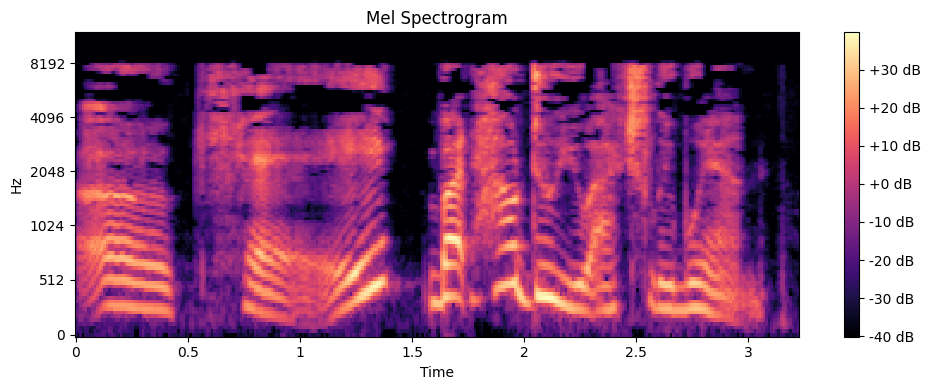

In [29]:
from pathlib import Path
import torchaudio
from omegaconf import OmegaConf # omegaconf 支持 YAML 格式配置文件
import string
import matplotlib.pyplot as plt
import librosa.display

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

class MyAudio:
    def __init__(
        self,
        audio_path,
        transcription,
        target_sample_rate,
        n_mel_channels,
        hop_length,
        win_length,
        n_fft
    ):
        self.audio_path = audio_path
        self.transcription = transcription
        self.target_sample_rate = target_sample_rate
        self.duration = torchaudio.info(str(audio_path)).num_frames / target_sample_rate
        self.tokens = self.create_tokens()
        self.n_mel_channels = n_mel_channels
        self.hop_length = hop_length
        self.win_length = win_length
        self.n_fft = n_fft
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.target_sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mel_channels
        )
    
    def __call__(self):
        waveform, ori_sample_rate = torchaudio.load(self.audio_path)
        if ori_sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=ori_sample_rate, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)          # shape: (C, N_out)
        mel_spec = self.mel_spectrogram(waveform)   # shape: (C, N_mels, T)
        return {
            "mel_spec": mel_spec,
            "tokens": self.tokens
        }

    # 返回mel spectrogram帧长
    def __len__(self):
        return int(self.duration * self.target_sample_rate / self.hop_length)
    
    # 返回第index个token
    def __getitem__(self, index):
        return self.tokens[index]
    
    # 返回音频基本信息
    def __str__(self):
        return f"The duration of \"{self.audio_path}\" is {self.duration}s.\nTranscription: \"{self.transcription}\""

    # 词级别分词
    def create_tokens(self):
        transcription_processed = ''.join([c for c in self.transcription if c not in string.punctuation])
        tokens = transcription_processed.strip().split()
        return tokens

    # 画mel spectrogram
    def plot_mel_spectrogram(
        self,
        mel, 
        x_axis='time', 
        y_axis='mel', 
        cmap='magma', 
        title='Mel Spectrogram', 
        figsize=(10, 4),
        db_ref=1.0,
        db_top_db=80.0
    ):
        mel = mel.detach().cpu().numpy()
        S_db = librosa.power_to_db(mel, ref=db_ref, top_db=db_top_db)
        plt.figure(figsize=figsize)
        librosa.display.specshow(
            S_db,
            sr=self.target_sample_rate,
            hop_length=self.hop_length,
            x_axis=x_axis,
            y_axis=y_axis,
            cmap=cmap
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()

input_dir = Path("test_data")
text_path = input_dir / "1.txt"
audio_path = input_dir / "1.mp3"
config_path = input_dir / "mel_spec.yaml"
with open(text_path, 'r') as f:
    transcription = f.readline()

cfg = OmegaConf.load(config_path)

myAudio = MyAudio(audio_path, transcription, **cfg.mel_spec)
print("--------------------------------------")
print(f"myAudio: \n{myAudio}")          # 调用__str__
print("--------------------------------------")
print(f"len(myAudio): {len(myAudio)}")  # 调用__len__
print("--------------------------------------")
print(f"myAudio[0]: {myAudio[0]}")      # 调用__getitem__
print("--------------------------------------")
mel_spec, tokens = myAudio().values()   # 调用__call__
print(f"myAudio()[\"tokens\"]: {tokens}")
print("--------------------------------------")
myAudio.plot_mel_spectrogram(mel_spec[0])

## 3. 继承

继承允许我们定义一个类继承另一个类的属性和方法。

- 基类/父类: 被继承的类
- 派生类/子类: 继承其他类的类
- 继承的主要作用:
  - 代码重用: 子类可以直接使用父类的属性和方法
  - 扩展功能: 子类可以添加新的属性和方法
  - 方法重写: 子类可以重新实现父类的方法(override)

常见继承相关操作:
- 调用父类方法: `super().方法名()`

继承的常见例子：抽象类`torch.utils.data.dataset`

- 因为`torch.utils.data.dataset`是抽象类，不能实例化，所以需要构造该抽象类的子类创建数据集，并重写父类的方法，其中`__len__`和`__getitem__`是两个必须要重写的方法
  - `__len__`: 返回数据集大小
  - `__getitem__`: 根据索引获取数据和标签

```py
from torch.utils.data import Dataset

# 创建自定义数据集类，继承自Dataset
class CustomDataset(Dataset):
    def __init__(self, data_path):
        self.data = [...] # 存放数据
        self.labels = [...] # 存放标签
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data[index]
        label = self.labels[index]
        return data, label
```